<a href="https://colab.research.google.com/github/seanpaz478/AAI540_Final_Project_Group5/blob/main/EDA_for_PISA_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install s3fs

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency
from sklearn.feature_selection import mutual_info_regression, chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

In [24]:
# Load data from S3
df = pd.read_csv('s3://aai540group5/us_df.csv')
print(f"Dataset has {len(df)} rows and {len(df.columns)} columns")

Dataset has 38222 rows and 942 columns


# Basic EDA

In [25]:
# First rows
df.head()

,CNTRYID_qqq,CNT_qqq,CNTSCHID_qqq,CNTSTUID,CYC_qqq,NatCen_qqq,Region_qqq,STRATUM_qqq,SUBNATIO_qqq,OECD_qqq,...,ST016Q01NA,ST038Q01NA,ST038Q02NA,ST038Q03NA,ST038Q04NA,ST038Q05NA,ST038Q06NA,ST038Q07NA,ST038Q08NA,ANX_BAND_Q3_US
0,Australia,Australia,3600001.0,3610676.0,06MS,Australia,Australia,"AUS - stratum 21: QLD-Gov, Y10",Australia,Yes,...,NaN,NaN,NaN,Never or almost never,Never or almost never,Never or almost never,Never or almost never,Never or almost never,Never or almost never,medium
1,Australia,Australia,3600001.0,3611874.0,06MS,Australia,Australia,"AUS - stratum 21: QLD-Gov, Y10",Australia,Yes,...,NaN,NaN,NaN,Never or almost never,A few times a year,Never or almost never,Never or almost never,Never or almost never,Never or almost never,medium
2,Australia,Australia,3600001.0,3601769.0,06MS,Australia,Australia,"AUS - stratum 21: QLD-Gov, Y10",Australia,Yes,...,NaN,NaN,NaN,A few times a month,A few times a month,Once a week or more,Never or almost never,A few times a month,Once a week or more,high
3,Australia,Australia,3600001.0,3605996.0,06MS,Australia,Australia,"AUS - stratum 21: QLD-Gov, Y10",Australia,Yes,...,NaN,NaN,NaN,A few times a year,Never or almost never,Never or almost never,Never or almost never,Never or almost never,Never or almost never,medium
4,Australia,Australia,3600001.0,3608147.0,06MS,Australia,Australia,"AUS - stratum 21: QLD-Gov, Y10",Australia,Yes,...,NaN,NaN,NaN,Never or almost never,A few times a year,Never or almost never,Never or almost never,Never or almost never,Never or almost never,medium


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38222 entries, 0 to 38221
Columns: 942 entries, CNTRYID_qqq to ANX_BAND_Q3_US
dtypes: float64(437), object(505)
memory usage: 274.7+ MB


In [27]:
# Statistical summary
df.describe()

,CNTSCHID_qqq,CNTSTUID,LANGTEST_PAQ,ST003D03T,ST059Q01TA,ST059Q02TA,ST059Q03TA,ST060Q01NA,ST061Q01NA,ST071Q01NA,...,PV6SSES,PV7SSES,PV8SSES,PV9SSES,PV10SSES,SENWT,CNTSCHID_qq2,ST016Q01NA,ST038Q01NA,ST038Q02NA
count,3.822200e+04,3.822200e+04,0.0,33285.000000,34541.000000,34523.000000,34328.000000,34952.000000,35116.000000,28554.000000,...,36824.000000,36824.000000,36824.000000,36824.000000,36824.000000,38222.000000,3.822200e+04,21625.000000,0.0,0.0
mean,3.611848e+07,3.612508e+07,NaN,1999.358450,3.808431,4.159864,4.762555,31.162194,56.300689,5.286545,...,497.101131,497.359598,497.012220,496.942242,498.032819,0.915703,3.611848e+07,7.526890,NaN,NaN
std,3.783723e+07,3.783543e+07,NaN,0.479552,2.074980,1.882434,3.643298,12.673619,17.094328,7.074211,...,100.078151,100.458696,99.801411,99.624081,100.423822,0.965992,3.783723e+07,2.217696,NaN,NaN
min,3.600001e+06,3.600001e+06,NaN,1999.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,...,120.730000,114.399000,133.623000,123.305000,99.303000,0.019510,3.600001e+06,0.000000,NaN,NaN
25%,3.600509e+06,3.613614e+06,NaN,1999.000000,3.000000,3.000000,3.000000,25.000000,45.000000,2.000000,...,427.290750,427.477750,427.842250,427.117000,427.945000,0.390260,3.600509e+06,6.000000,NaN,NaN
50%,4.000178e+06,4.006996e+06,NaN,1999.000000,4.000000,4.000000,4.000000,30.000000,50.000000,4.000000,...,499.397000,499.549000,499.377500,498.800500,499.894500,0.640810,4.000178e+06,8.000000,NaN,NaN
75%,6.430020e+07,6.430598e+07,NaN,2000.000000,5.000000,5.000000,6.000000,36.000000,60.000000,6.000000,...,568.264250,568.455000,568.052250,567.730250,568.867250,0.941620,6.430020e+07,9.000000,NaN,NaN
max,9.730000e+07,9.731129e+07,NaN,2000.000000,40.000000,38.000000,40.000000,80.000000,120.000000,120.000000,...,872.038000,864.546000,846.249000,927.250000,876.504000,12.895870,9.730000e+07,10.000000,NaN,NaN


Target distribution

In [28]:
target = 'ANX_BAND_Q3_US'
df[target].value_counts()

,count
ANX_BAND_Q3_US,
low,11864
high,11851
medium,11850


Identify types of variables

In [29]:
achievement_cols = [
    col for col in df.columns
    if 'PV' in col and ('MATH' in col or 'READ' in col or 'SCIE' in col)
]

anxiety_cols = [
    col for col in df.columns
    if any(x in col.upper() for x in ['ANX', 'WORRY', 'STRESS'])
]

ses_cols = [
    col for col in df.columns
    if any(x in col for x in ['ESCS', 'HOMEPOS', 'WEALTH'])
]

demo_cols = [
    col for col in df.columns
    if any(x in col for x in ['GENDER', 'AGE', 'GRADE', 'ST004', 'ST003'])
]

wellbeing_questions = [
    col for col in df.columns
    if re.match(r'^ST(016|031|032|038|118|121|123)', col)
]


Other_rel_cols = [
    col for col in df.columns
    if any (x in col for x in ['EMO', 'SUP', 'BELONG', 'BULL', 'MOTIV', 'ST038'])
]

print(f"Achievement scores found: {len(achievement_cols)}")
print(achievement_cols)

print(f"Anxiety-related columns: {len(anxiety_cols)}")
print(anxiety_cols)

print(f"Socioeconomic columns: {len(ses_cols)}")
print(ses_cols)

print(f"Demographic columns: {len(demo_cols)}")
print(demo_cols)

print(f"Wellbeing Questions columns: {len(wellbeing_questions)}")
print(wellbeing_questions)

print(f"Other Relevant columns: {len(Other_rel_cols)}")
print(Other_rel_cols)

Achievement scores found: 30
['PV1MATH', 'PV2MATH', 'PV3MATH', 'PV4MATH', 'PV5MATH', 'PV6MATH', 'PV7MATH', 'PV8MATH', 'PV9MATH', 'PV10MATH', 'PV1READ', 'PV2READ', 'PV3READ', 'PV4READ', 'PV5READ', 'PV6READ', 'PV7READ', 'PV8READ', 'PV9READ', 'PV10READ', 'PV1SCIE', 'PV2SCIE', 'PV3SCIE', 'PV4SCIE', 'PV5SCIE', 'PV6SCIE', 'PV7SCIE', 'PV8SCIE', 'PV9SCIE', 'PV10SCIE']
Anxiety-related columns: 2
['ANXTEST', 'ANX_BAND_Q3_US']
Socioeconomic columns: 3
['HOMEPOS', 'WEALTH', 'ESCS']
Demographic columns: 5
['ST003D02T', 'ST003D03T', 'ST004D01T', 'AGE', 'GRADE']
Wellbeing Questions columns: 24
['ST123Q01NA', 'ST123Q02NA', 'ST123Q03NA', 'ST123Q04NA', 'ST118Q01NA', 'ST118Q02NA', 'ST118Q03NA', 'ST118Q04NA', 'ST118Q05NA', 'ST121Q01NA', 'ST121Q02NA', 'ST121Q03NA', 'ST031Q01NA', 'ST032Q01NA', 'ST032Q02NA', 'ST016Q01NA', 'ST038Q01NA', 'ST038Q02NA', 'ST038Q03NA', 'ST038Q04NA', 'ST038Q05NA', 'ST038Q06NA', 'ST038Q07NA', 'ST038Q08NA']
Other Relevant columns: 17
['TEACHSUP', 'BELONG', 'MOTIVAT', 'EMOSUPS', 'COMS

Merging/interpolating PV scores

Reason: Top features dominated by PV scores.

Subsequently discovered that the authors of PISA actually recommend this, as using each individual score is more statistically noisy, making interpolation more statistically sound.

In [30]:
# Find all PV columns and group by subject
pv_columns = [col for col in df.columns if col.startswith('PV')]
print(f"Found {len(pv_columns)} PV columns")

# Group PV columns by their subject (MATH, READ, SCIE, etc.)
pv_groups = {}
for col in pv_columns:
    match = re.match(r'PV\d+(.+)', col)

    if match:
        subject = match.group(1) # Extract the subject part (e.g., 'MATH')

        # Initialize list for this subject if we haven't seen it before
        if subject not in pv_groups:
            pv_groups[subject] = []

        # Add this column to the subject's list
        pv_groups[subject].append(col)

print(f"Found {len(pv_groups)} subjects: {list(pv_groups.keys())}")

# Average the PVs for each subject
for subject, cols in pv_groups.items():
    avg_col = f'PV_AVG_{subject}'
    sd_col  = f'PV_SD_{subject}'

    df[avg_col] = df[cols].mean(axis=1)
    df[sd_col]  = df[cols].std(axis=1)

    print(f"Created {avg_col} and {sd_col} from {len(cols)} columns")

# Drop the original PV columns
df = df.drop(columns=pv_columns)

print(f"\nDataset shape after: {df.shape}")
print(f"Reduced by {len(pv_columns) - len(pv_groups)} columns!")

Found 110 PV columns
Found 11 subjects: ['MATH', 'READ', 'SCIE', 'SCEP', 'SCED', 'SCID', 'SKCO', 'SKPE', 'SSPH', 'SSLI', 'SSES']
Created PV_AVG_MATH and PV_SD_MATH from 10 columns
Created PV_AVG_READ and PV_SD_READ from 10 columns
Created PV_AVG_SCIE and PV_SD_SCIE from 10 columns
Created PV_AVG_SCEP and PV_SD_SCEP from 10 columns
Created PV_AVG_SCED and PV_SD_SCED from 10 columns
Created PV_AVG_SCID and PV_SD_SCID from 10 columns
Created PV_AVG_SKCO and PV_SD_SKCO from 10 columns
Created PV_AVG_SKPE and PV_SD_SKPE from 10 columns
Created PV_AVG_SSPH and PV_SD_SSPH from 10 columns
Created PV_AVG_SSLI and PV_SD_SSLI from 10 columns
Created PV_AVG_SSES and PV_SD_SSES from 10 columns

Dataset shape after: (38222, 854)
Reduced by 99 columns!


Missing Values:

In [31]:
# Detailed breakdown
missing_pct = (df.isnull().sum() / len(df) * 100)
total_cols = len(df.columns)

print("Missing Data Distribution:")
for i in range(0, 101, 10):
    count = ((missing_pct >= i) & (missing_pct < i + 10)).sum()
    pct_of_cols = (count / total_cols) * 100
    print(f"{i:3d}-{i+10:3d}% missing: {count:4d} columns ({pct_of_cols:.1f}% of all columns)")

Missing Data Distribution:
  0- 10% missing:  260 columns (30.4% of all columns)
 10- 20% missing:  133 columns (15.6% of all columns)
 20- 30% missing:   23 columns (2.7% of all columns)
 30- 40% missing:   77 columns (9.0% of all columns)
 40- 50% missing:   21 columns (2.5% of all columns)
 50- 60% missing:    0 columns (0.0% of all columns)
 60- 70% missing:    2 columns (0.2% of all columns)
 70- 80% missing:   32 columns (3.7% of all columns)
 80- 90% missing:  122 columns (14.3% of all columns)
 90-100% missing:   26 columns (3.0% of all columns)
100-110% missing:  158 columns (18.5% of all columns)


Removing non-informative columns (high missing, IDs, etc.)

In [32]:
# Remove high missing column
cols_low_missing = missing_pct[missing_pct < 20].index.tolist()
print(f"low missing columns: {len(cols_low_missing)}")

# Removing other non-informative columns (ex. ID columns)
exclude_patterns = r'^(W_|CNTSTUID|SCHOOLID|STIDSTD|BOOKID|ID|VERSION|OECD|OPTION|SENWT|VER_)'
informative_cols = []

for col in cols_low_missing:
    if re.match(exclude_patterns, col, re.IGNORECASE): # Skip excluded patterns
        continue

    # Exclude columns where all columns are the same or almost all different
    n_unique = df[col].round(4).nunique()
    if 1 < n_unique < len(df) * 0.995:
        informative_cols.append(col)

print(f"Informative columns: {len(informative_cols)}")


low missing columns: 393
Informative columns: 295


## FEATURE SELECTION (SIMPLE)

In [33]:
# Get numeric columns with reasonable missing data
numeric_cols = df[informative_cols].select_dtypes(include=[np.number]).columns.tolist()
if target in numeric_cols:
    numeric_cols.remove(target)

# Calculate ANOVA F-scores for top features (since target is categorical)
from scipy.stats import f_oneway

f_scores = []
for col in numeric_cols:
    # Get values for each anxiety band
    groups = []
    for band in df[target].dropna().unique():
        group_vals = df[df[target] == band][col].dropna()
        groups.append(group_vals)

    f_stat, p_val = f_oneway(*groups)
    f_scores.append((col, f_stat))

# Sort by F-score
f_scores.sort(key=lambda x: x[1], reverse=True)

print(f"\nTop 50 predictive features:")
for i, (col, score) in enumerate(f_scores[:100], 1):
    print(f"{i:2d}. {col[:40]:<40} F-score: {score:.2f}")

# Save top features
top_features = [col for col, _ in f_scores[:50]]



Top 50 predictive features:
 1. ANXTEST                                  F-score: 45672.94
 2. PV_AVG_MATH                              F-score: 738.86
 3. BELONG                                   F-score: 735.82
 4. PV_AVG_SKCO                              F-score: 647.53
 5. PV_AVG_SCEP                              F-score: 645.57
 6. PV_AVG_SSPH                              F-score: 540.73
 7. PV_AVG_SSES                              F-score: 538.35
 8. PV_AVG_SCIE                              F-score: 521.25
 9. PV_AVG_SCID                              F-score: 473.77
10. PV_AVG_SSLI                              F-score: 463.98
11. PV_AVG_SKPE                              F-score: 428.27
12. PV_AVG_SCED                              F-score: 354.40
13. unfairteacher                            F-score: 284.26
14. SCIEEFF                                  F-score: 234.14
15. PV_AVG_READ                              F-score: 215.95
16. DISCLISCI                                F-score: 

In [34]:
from scipy.stats import chi2_contingency

categorical_cols = df[informative_cols].select_dtypes(include=['object', 'category']).columns.tolist()
chi_scores = []

for col in categorical_cols:
    # Create a contingency table (crosstab)
    contingency_table = pd.crosstab(df[col], df[target])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    chi_scores.append((col, chi2))

# Sort by Chi-Squared statistic
chi_scores.sort(key=lambda x: x[1], reverse=True)

print("\nTop 30 Categorical Features:")
print(chi_scores[:30])


Top 30 Categorical Features:
[('ANX_BAND_Q3_US', np.float64(71130.0)), ('ST118Q03NA', np.float64(25769.53787675469)), ('ST118Q01NA', np.float64(23923.833135836157)), ('ST118Q04NA', np.float64(20339.15852417316)), ('ST118Q02NA', np.float64(18559.021032473614)), ('ST118Q05NA', np.float64(16142.117110438496)), ('OCOD3', np.float64(2123.8808658954995)), ('ST034Q01TA', np.float64(1981.8602818842273)), ('ST034Q04TA', np.float64(1782.3583488193492)), ('ST004D01T', np.float64(1751.6598978946295)), ('OCOD2', np.float64(1734.0582659017923)), ('ST034Q06TA', np.float64(1669.1290706084683)), ('OCOD1', np.float64(1668.5864521810754)), ('STRATUM_qq2', np.float64(1243.273159021189)), ('STRATUM_qqq', np.float64(1210.4982032370242)), ('COBN_F', np.float64(1112.4691788328407)), ('COBN_M', np.float64(1101.2218646136578)), ('LANGN', np.float64(1076.0774393705817)), ('PROGN', np.float64(988.6073077747283)), ('COBN_S', np.float64(980.715981852986)), ('ST011D18TA', np.float64(964.20770234156)), ('ST034Q03TA'

Visualization

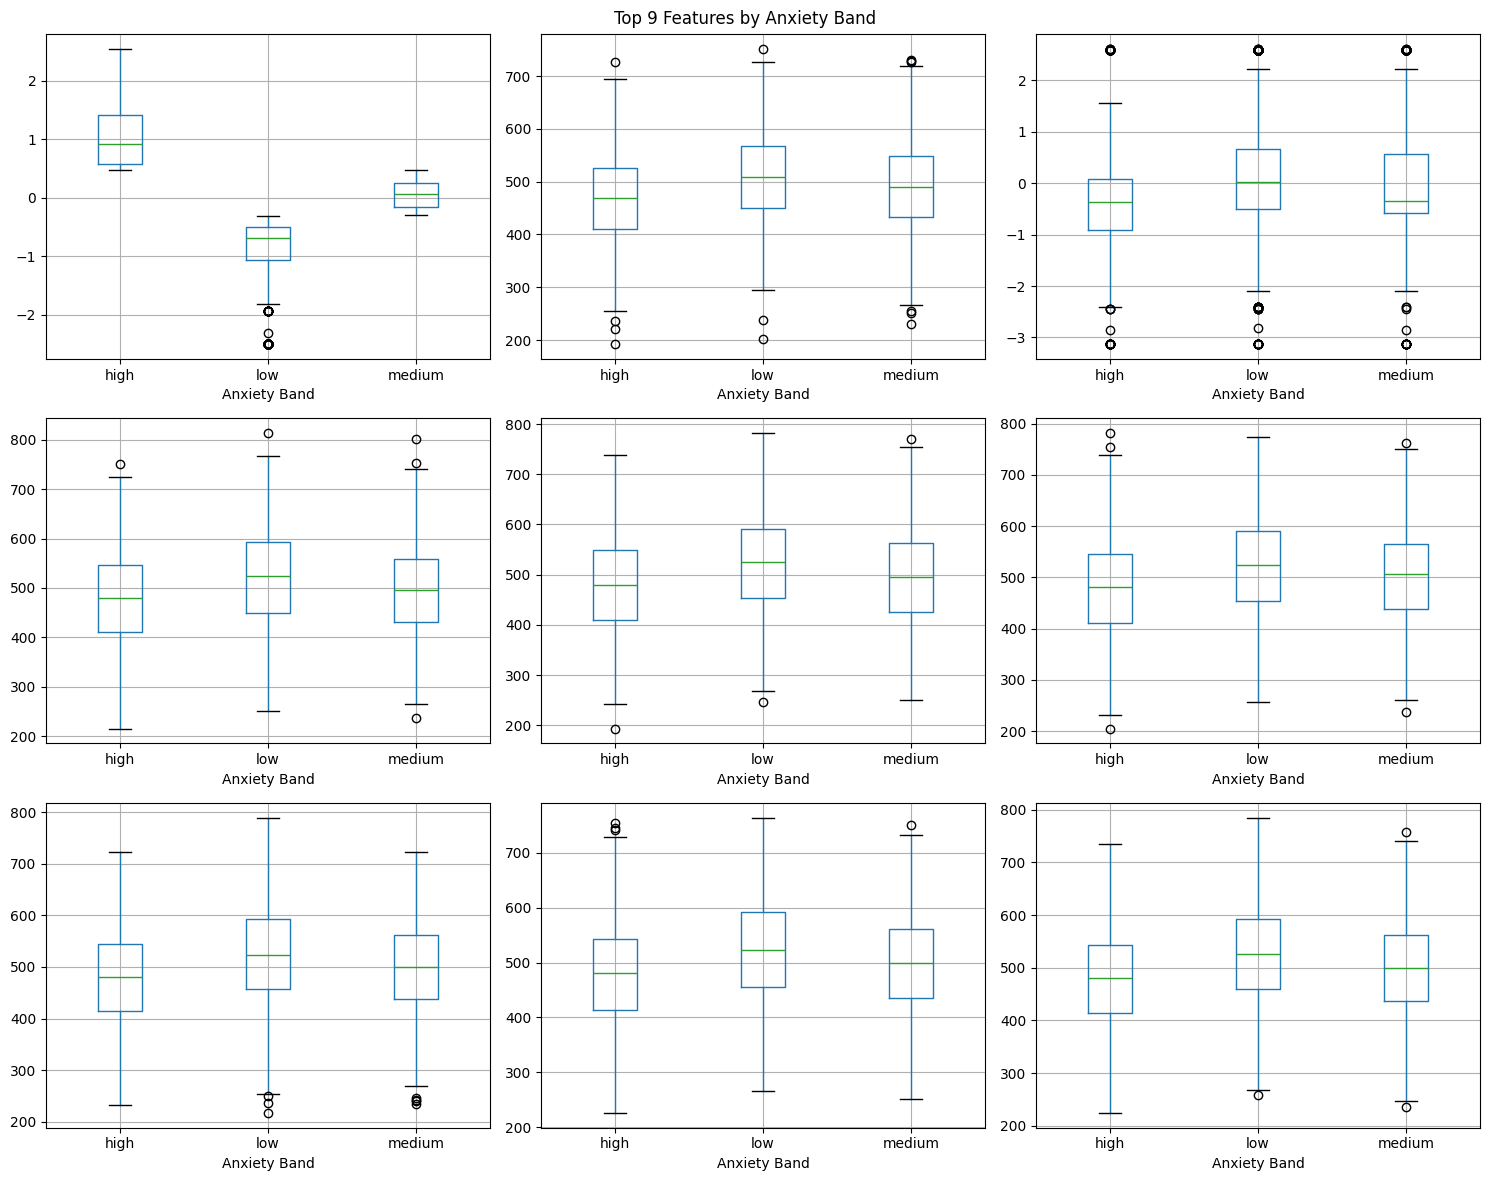

In [35]:
# Plot top 9 features vs target
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_features[:9]):
    # Sample data if large
    plot_df = df[[feature, target]].dropna()
    if len(plot_df) > 5000:
        plot_df = plot_df.sample(5000)

    # Box plot
    plot_df.boxplot(column=feature, by=target, ax=axes[idx])
    axes[idx].set_title('')
    axes[idx].set_xlabel('Anxiety Band')

plt.suptitle('Top 9 Features by Anxiety Band')
plt.tight_layout()
plt.show()


Correlation Check

Highly correlated pairs (|r| > 0.8):
  PV_AVG_MATH <-> PV_AVG_SKCO: 0.91
  PV_AVG_MATH <-> PV_AVG_SCEP: 0.91
  PV_AVG_MATH <-> PV_AVG_SSPH: 0.91
  PV_AVG_MATH <-> PV_AVG_SSES: 0.91
  PV_AVG_MATH <-> PV_AVG_SCIE: 0.93


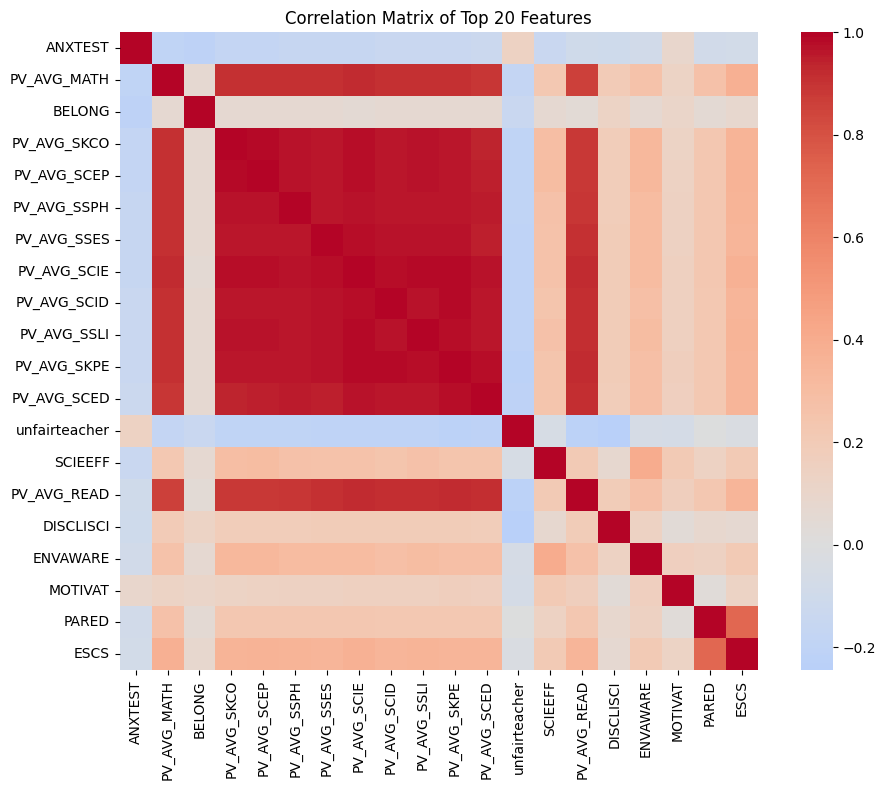

In [36]:
# Check correlations to avoid multicollinearity
corr_matrix = df[top_features[:20]].corr()

# Find high correlations
high_corr_pairs = []
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((corr_matrix.index[i], corr_matrix.index[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print("Highly correlated pairs (|r| > 0.8):")
    for var1, var2, corr in high_corr_pairs[:5]:
        print(f"  {var1[:20]} <-> {var2[:20]}: {corr:.2f}")
else:
    print("No highly correlated pairs found (good!)")

# Simple heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Top 20 Features')
plt.tight_layout()
plt.show()
